# 1. Introduction

## 1.1 Connecting to the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Importing the libraries

In [2]:
import os
import numpy as np
import gc #garbage collector
import random

from tqdm.notebook import tqdm #progress bar

from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, SensitivityAtSpecificity, SpecificityAtSensitivity, MeanIoU
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import plot_model

In [3]:
TASK = 1

if TASK == 1:
  os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/numpy_dataset/"
  os.environ["TASK"] = "task_1_lesion_segmentation"
  os.environ["NUMBER_OF_CLASSES"] = "1"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Training_GroundTruth")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str(os.environ["DATASET_PATH"] +  "ISIC2018_Task1_Test_GroundTruth")
elif TASK == 2:
  os.environ["DATASET_PATH"] = "/content/drive/MyDrive/skin_cancer/assets/data_aug_dataset_complete/"
  os.environ["TASK"] = "task_2_lesion_attribute_detection"
  os.environ["NUMBER_OF_CLASSES"] = "5"

  os.environ["TRAINING_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Training_GroundTruth_v3")
  os.environ["VALIDATION_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Validation_GroundTruth")
  os.environ["TEST_MASKS_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task2_Test_GroundTruth")

if TASK in [1, 2]:
  os.environ["TRAINING_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Training_Input")
  os.environ["VALIDATION_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1-2_Validation_Input")
  os.environ["TEST_IMAGES_PATH"] = str(os.environ["DATASET_PATH"] + "ISIC2018_Task1_and_2_Test_Input")

  os.environ["VALIDATION_COUNT"] = "100"
  os.environ["TRAINING_COUNT"] = "2594"
  os.environ["TEST_COUNT"] = "1000"

  # os.environ["VALIDATION_COUNT"] = "20"
  # os.environ["TRAINING_COUNT"] = "622"
  # os.environ["TEST_COUNT"] = "1000"

## 1.3 Defining global variables

In [4]:
IM_HEIGHT = 256
IM_WIDTH = 256

# 2. Modeling

## 2.1 defining the model (U-net)

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters, kernel_size=2):
    x = Conv2DTranspose(num_filters, (kernel_size, kernel_size), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [6]:
#Unet Architecture --https://idiotdeveloper.com/vgg16-unet-implementation-in-tensorflow/
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def build_vgg16_unet(input_img, num_filters=16, kernel_size=3, dropout=0.2, batchnorm=True):
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=input_img)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512) ## (64 x 64)
    d2 = decoder_block(d1, s3, 256) ## (128 x 128)
    d3 = decoder_block(d2, s2, 128) ## (256 x 256)
    d4 = decoder_block(d3, s1, 64) ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs=[input_img], outputs=[outputs], name="VGG16_U-Net")
    return model

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)

  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred): #Jaccard
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

  return intersection/union

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))

  return true_negatives / (possible_negatives + K.epsilon())

# 3 Results

In [8]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, dice_coef, SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5)]

#initialize params
n_filters = 32
kernel_size = 5
dropout = 0.1
batch_size = 32
epochs = 20
optimizer = Adam()

#Loading converted images into arrays
TRAINING_IMAGES = np.load(os.environ["TRAINING_IMAGES_PATH"] + "/ISIC2018_Task1-2_Training_Input.npy")
TRAINING_MASKS = np.load(os.environ["TRAINING_MASKS_PATH"] + "/ISIC2018_Task1_Training_GroundTruth.npy")

VALIDATION_IMAGES = np.load(os.environ["VALIDATION_IMAGES_PATH"] + "/ISIC2018_Task1-2_Validation_Input.npy")
VALIDATION_MASKS = np.load(os.environ["VALIDATION_MASKS_PATH"] + "/ISIC2018_Task1_Validation_GroundTruth.npy")

# TRAINING_IMAGES = TRAINING_IMAGES[:500]
# TRAINING_MASKS = TRAINING_MASKS[:500]
# VALIDATION_IMAGES = VALIDATION_IMAGES[:50]
# VALIDATION_MASKS = VALIDATION_MASKS[:50]

In [9]:
#Instantiate Keras tensor
input_img = Input((IM_HEIGHT, IM_WIDTH, 3), name='img')
metrics=[Accuracy(), Precision(), Recall(), iou, specificity, dice_coef]

# create model
model = build_vgg16_unet(input_img, num_filters=n_filters, kernel_size=kernel_size, dropout=dropout)
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
# Carrega os pesos
model.load_weights(f'/content/drive/MyDrive/skin_cancer/models/unet/assets/unet13_drop_{n_filters}_{kernel_size}_{batch_size}_{epochs}_lesion.h5') #/content/drive/MyDrive/skin_cancer/models/unet/assets/unet_16_5_32_50.h5

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# model.summary()

In [ ]:
# plot_model(model, "my_first_model.png")

In [10]:
model.evaluate(VALIDATION_IMAGES, VALIDATION_MASKS, verbose=1)

4/4 [==============================] - 135s 30s/step - loss: 0.2582 - accuracy: 1.5259e-07 - precision_1: 0.9460 - recall_1: 0.7264 - iou: 0.5233 - specificity: 0.9788 - dice_coef: 0.6864


[0.2581597864627838,
 1.5258788721439487e-07,
 0.9460059404373169,
 0.7264236807823181,
 0.5233113765716553,
 0.9788147211074829,
 0.6863723397254944]

In [11]:
preds_val = model.predict(VALIDATION_IMAGES, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

4/4 [==============================] - 136s 30s/step


In [12]:
def plot_sample_results(X, y, preds, binary_preds, has_mask):
    ix = random.randint(0, len(X))
    # ix = 84

    fig, ax = plt.subplots(1, 4, figsize=(20,10))

    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[0].set_title('real mask')

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[1].set_title('cancer Predicted')

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('cancer Predicted Binary')

    ax[3].imshow(X[ix])
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[3].contour(binary_preds[ix].squeeze(), colors='m', levels=[0.5])
    ax[3].set_title('cancer')

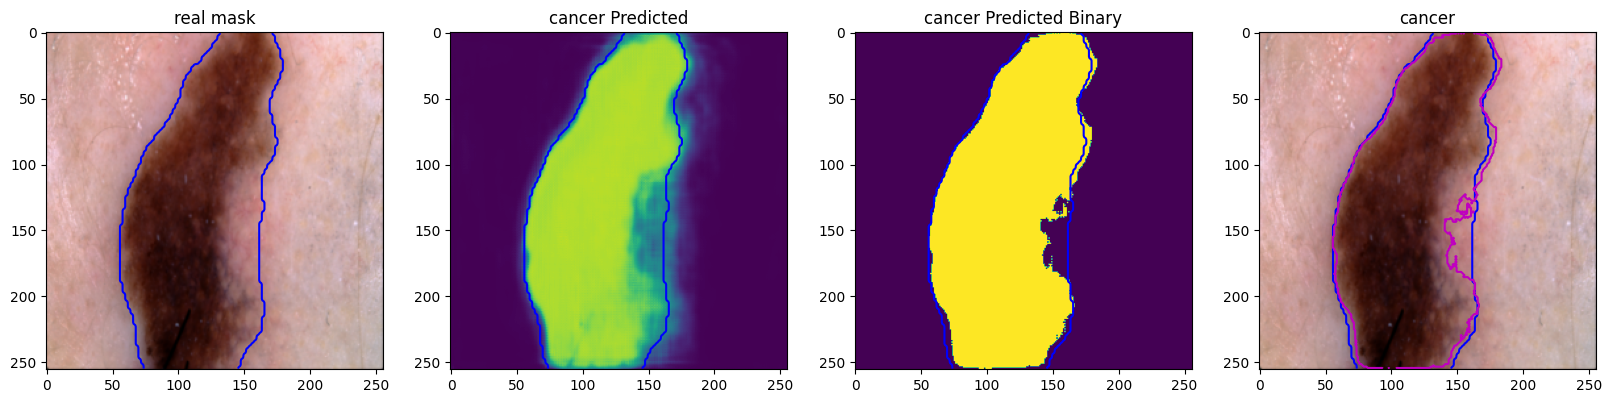

In [15]:
## Predictions on Test Set
plot_sample_results(X=VALIDATION_IMAGES, y=VALIDATION_MASKS, preds=preds_val, binary_preds=preds_val_t, has_mask=True)